---
title: Quasi-Separation and Regularized Logistic Regression
subtitle: Car Safety Rating
date: 2025-03-31
from: markdown+emoji
execute: 
  eval: false
---

# Settings

In [ ]:
# Below is for an interactive display of Pandas DataFrame in Colab
from google.colab import data_table
data_table.enable_dataframe_formatter()

import pandas as pd
import numpy as np
from tabulate import tabulate  # for table summary
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # for lowess smoothing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, avg, when, log, sqrt, exp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.master("local[*]").getOrCreate()

## UDFs

### add_dummy_variables

In [ ]:
#| code-fold: true
def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


# Example usage without category_order:
# dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

### marginal_effects

In [ ]:
#| code-fold: true
def marginal_effects(model, means):
    """
    Compute marginal effects for all predictors in a PySpark GeneralizedLinearRegression model (logit)
    and return a formatted table with statistical significance and standard errors.

    Parameters:
        model: Fitted GeneralizedLinearRegression model (with binomial family and logit link).
        means: List of mean values for the predictor variables.

    Returns:
        - A formatted string containing the marginal effects table.
        - A Pandas DataFrame with marginal effects, standard errors, confidence intervals, and significance stars.
    """
    global assembler_predictors  # Use the global assembler_predictors list

    # Extract model coefficients, standard errors, and intercept
    coeffs = np.array(model.coefficients)
    std_errors = np.array(model.summary.coefficientStandardErrors)
    intercept = model.intercept

    # Compute linear combination of means and coefficients (XB)
    XB = np.dot(means, coeffs) + intercept

    # Compute derivative of logistic function (G'(XB))
    G_prime_XB = np.exp(XB) / ((1 + np.exp(XB)) ** 2)

    # Helper: significance stars.
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Create lists to store results
    results = []
    df_results = []  # For Pandas DataFrame

    for i, predictor in enumerate(assembler_predictors):
        # Compute marginal effect
        marginal_effect = G_prime_XB * coeffs[i]

        # Compute standard error of the marginal effect
        std_error = G_prime_XB * std_errors[i]

        # Compute z-score and p-value
        z_score = marginal_effect / std_error if std_error != 0 else np.nan
        p_value = 2 * (1 - norm.cdf(abs(z_score))) if not np.isnan(z_score) else np.nan

        # Compute confidence interval (95%)
        ci_lower = marginal_effect - 1.96 * std_error
        ci_upper = marginal_effect + 1.96 * std_error

        # Append results for table formatting
        results.append([
            predictor,
            f"{marginal_effect: .4f}",
            significance_stars(p_value),
            f"{std_error: .4f}",
            f"{ci_lower: .4f}",
            f"{ci_upper: .4f}"
        ])

        # Append results for Pandas DataFrame
        df_results.append({
            "Variable": predictor,
            "Marginal Effect": marginal_effect,
            "Significance": significance_stars(p_value),
            "Std. Error": std_error,
            "95% CI Lower": ci_lower,
            "95% CI Upper": ci_upper
        })

    # Convert results to formatted table
    table_str = tabulate(results, headers=["Variable", "Marginal Effect", "Significance", "Std. Error", "95% CI Lower", "95% CI Upper"],
                         tablefmt="pretty", colalign=("left", "decimal", "left", "decimal", "decimal", "decimal"))

    # Convert results to Pandas DataFrame
    df_results = pd.DataFrame(df_results)

    return table_str, df_results

# Example usage:
# means = [0.5, 30]  # Mean values for x1 and x2
# assembler_predictors = ['x1', 'x2']  # Define globally before calling the function
# table_output, df_output = marginal_effects(fitted_model, means)
# print(table_output)
# display(df_output)

# Data Preparation

## Loading Data

In [ ]:
dfpd = pd.read_csv('https://bcdanl.github.io/data/car-data.csv')
df = spark.createDataFrame(dfpd)
dfpd

,buying,maint,doors,persons,lug_boot,safety,rating,fail
0,vhigh,vhigh,2,2,small,low,unacc,1
1,vhigh,vhigh,2,2,small,med,unacc,1
2,vhigh,vhigh,2,2,small,high,unacc,1
3,vhigh,vhigh,2,2,med,low,unacc,1
4,vhigh,vhigh,2,2,med,med,unacc,1
...,...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good,0
1724,low,low,5more,more,med,high,vgood,0
1725,low,low,5more,more,big,low,unacc,1
1726,low,low,5more,more,big,med,good,0


## Training-Test Data Split

In [ ]:
dtrain, dtest = df.randomSplit([0.7, 0.3], seed = 1234)

## Adding Dummies

In [ ]:
dfpd['buying'].unique() # to see categories in GESTREC3 using the pandas' unique() method

array(['vhigh', 'high', 'med', 'low'], dtype=object)

In [ ]:
dfpd['maint'].unique() # to see categories in DPLURAL

array(['vhigh', 'high', 'med', 'low'], dtype=object)

In [ ]:
dfpd['doors'].unique()

array(['2', '3', '4', '5more'], dtype=object)

In [ ]:
dfpd['persons'].unique()

array(['2', '4', 'more'], dtype=object)

In [ ]:
dfpd['lug_boot'].unique()

array(['small', 'med', 'big'], dtype=object)

In [ ]:
dfpd['safety'].unique()

array(['low', 'med', 'high'], dtype=object)

In [ ]:

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

custom_order_buying = ['low', 'med', 'high', 'vhigh']
custom_order_maint = ['low', 'med', 'high', 'vhigh']
custom_order_persons = ['2', '4', 'more']
custom_order_lug_boot = ['small', 'med', 'big']
custom_order_safety = ['low', 'med', 'high']
dummy_cols_buying, ref_category_buying = add_dummy_variables('buying', 0, category_order = custom_order_buying)
dummy_cols_maint, ref_category_maint = add_dummy_variables('maint', 0, category_order = custom_order_maint)
dummy_cols_persons, ref_category_persons = add_dummy_variables('persons', 0, category_order = custom_order_persons)
dummy_cols_lug_boot, ref_category_lug_boot = add_dummy_variables('lug_boot', 0, category_order = custom_order_lug_boot)
dummy_cols_safety, ref_category_safety = add_dummy_variables('safety', 0, category_order = custom_order_safety)


Reference category (dummy omitted): low
Reference category (dummy omitted): low
Reference category (dummy omitted): 2
Reference category (dummy omitted): small
Reference category (dummy omitted): low


# Model

## Assembling Predictors

In [ ]:
# Keep the name assembler_predictors unchanged,
#   as it will be used as a global variable in the marginal_effects UDF.
assembler_predictors = (
    dummy_cols_buying +
    dummy_cols_maint + dummy_cols_persons + dummy_cols_lug_boot + dummy_cols_safety
)

assembler_1 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_1 = assembler_1.transform(dtrain)
dtest_1  = assembler_1.transform(dtest)

## Model Fitting


In [ ]:
# training the model
model_1 = (
    GeneralizedLinearRegression(featuresCol="predictors",
                                labelCol="fail",
                                family="binomial",
                                link="logit")
    .fit(dtrain_1)
)

## Making Predictions

In [ ]:
# making prediction on both training and test
dtrain_1 = model_1.transform(dtrain_1)
dtest_1 = model_1.transform(dtest_1)

dtrain_1 = dtrain_1.withColumnRenamed("prediction", "prediction_lr")
dtest_1 = dtest_1.withColumnRenamed("prediction", "prediction_lr")

## Model Summary

In [ ]:
model_1.summary

Coefficients:
     Feature Estimate  Std Error T Value P Value
 (Intercept)  58.0307 18024.5736  0.0032  0.9974
  buying_med   1.2332     0.5087  2.4244  0.0153
 buying_high   4.0189     0.5564  7.2235  0.0000
buying_vhigh   6.1115     0.6466  9.4511  0.0000
   maint_med   0.7337     0.4891  1.5001  0.1336
  maint_high   3.3288     0.5057  6.5825  0.0000
 maint_vhigh   5.5843     0.6280  8.8919  0.0000
   persons_4 -31.9209 12536.9296 -0.0025  0.9980
persons_more -31.5619 12536.9296 -0.0025  0.9980
lug_boot_med  -2.3314     0.3962 -5.8847  0.0000
lug_boot_big  -3.7045     0.4693 -7.8938  0.0000
  safety_med -30.2105 12950.2144 -0.0023  0.9981
 safety_high -32.3235 12950.2144 -0.0025  0.9980

(Dispersion parameter for binomial family taken to be 1.0000)
   Null deviance: 1508.4768 on 1230 degrees of freedom
Residual deviance: 291.5923 on 1230 degrees of freedom
AIC: 317.5923

# Classification

## Classifier Threshold - Double Density Plot

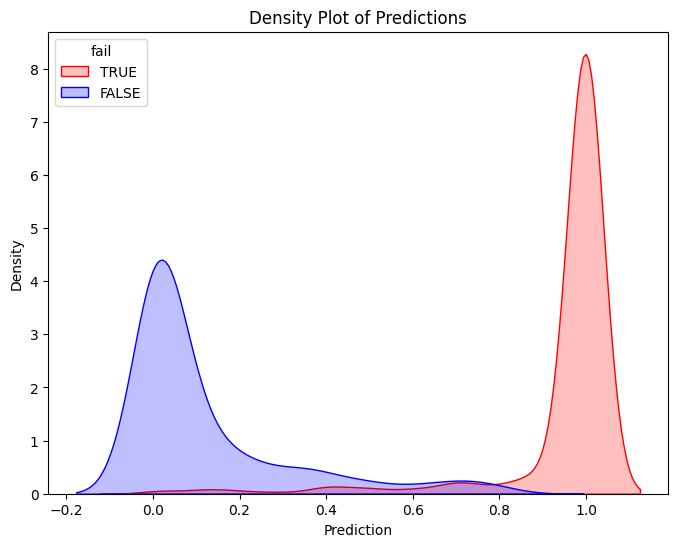

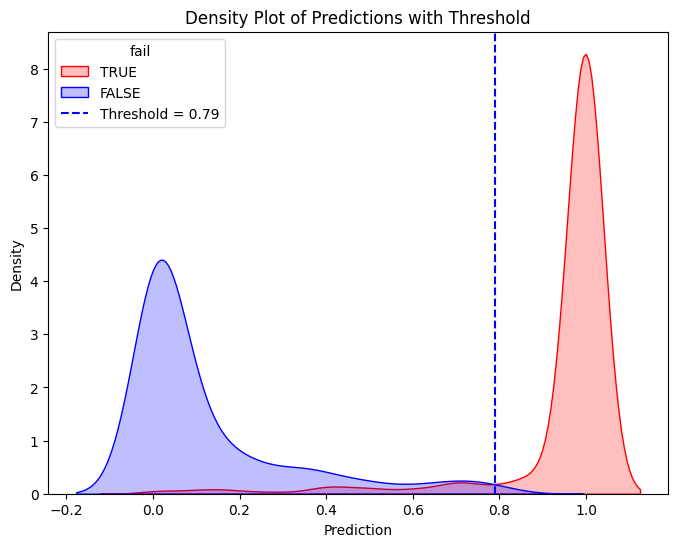

In [ ]:
# Filter training data for atRisk == 1 and atRisk == 0
pdf = dtrain_1.select("prediction_lr", "fail").toPandas()

train_true = pdf[pdf["fail"] == 1]
train_false = pdf[pdf["fail"] == 0]

# Create the first density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(train_true["prediction_lr"], label="TRUE", color="red", fill=True)
sns.kdeplot(train_false["prediction_lr"], label="FALSE", color="blue", fill=True)
plt.xlabel("Prediction")
plt.ylabel("Density")
plt.title("Density Plot of Predictions")
plt.legend(title="fail")
plt.show()

# Define threshold for vertical line
threshold = 0.79  # Replace with actual value

# Create the second density plot with vertical line
plt.figure(figsize=(8, 6))
sns.kdeplot(train_true["prediction_lr"], label="TRUE", color="red", fill=True)
sns.kdeplot(train_false["prediction_lr"], label="FALSE", color="blue", fill=True)
plt.axvline(x=threshold, color="blue", linestyle="dashed", label=f"Threshold = {threshold}")
plt.xlabel("Prediction")
plt.ylabel("Density")
plt.title("Density Plot of Predictions with Threshold")
plt.legend(title="fail")
plt.show()

## Performance of Classifier

### Confusion Matrix & Performance Metrics

In [ ]:
# Compute confusion matrix
dtest_1 = dtest_1.withColumn("predicted_class", when(col("prediction_lr") > .79, 1).otherwise(0))
conf_matrix = dtest_1.groupBy("fail", "predicted_class").count().orderBy("fail", "predicted_class")

TP = dtest_1.filter((col("fail") == 1) & (col("predicted_class") == 1)).count()
FP = dtest_1.filter((col("fail") == 0) & (col("predicted_class") == 1)).count()
FN = dtest_1.filter((col("fail") == 1) & (col("predicted_class") == 0)).count()
TN = dtest_1.filter((col("fail") == 0) & (col("predicted_class") == 0)).count()

accuracy = (TP + TN) / (TP + FP + FN + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
average_rate = (TP + FN) / (TP + TN + FP + FN)  # Proportion of actual at-risk babies
enrichment = precision / average_rate


# Print formatted confusion matrix with labels
print("\n Confusion Matrix:\n")
print("                     Predicted")
print("            |  Negative  |  Positive  ")
print("------------+------------+------------")
print(f"Actual Neg. |    {TN:5}   |    {FP:5}  |")
print("------------+------------+------------")
print(f"Actual Pos. |    {FN:5}   |    {TP:5}  |")
print("------------+------------+------------")


print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity:  {specificity:.4f}")
print(f"Average Rate: {average_rate:.4f}")
print(f"Enrichment:   {enrichment:.4f} (Relative Precision)")



 Confusion Matrix:

                     Predicted
            |  Negative  |  Positive  
------------+------------+------------
Actual Neg. |      150   |        1  |
------------+------------+------------
Actual Pos. |       20   |      314  |
------------+------------+------------
Accuracy:  0.9567
Precision: 0.9968
Recall (Sensitivity): 0.9401
Specificity:  0.9934
Average Rate: 0.6887
Enrichment:   1.4475 (Relative Precision)


### Trade-off Between Recall and Precision/Enrichment

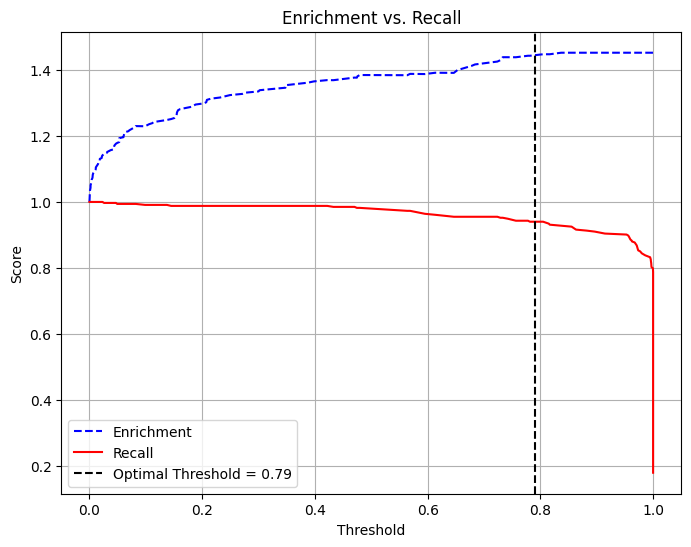

In [ ]:
pdf = dtest_1.select("prediction_lr", "fail").toPandas()

# Extract predictions and true labels
y_true = pdf["fail"]  # True labels
y_scores = pdf["prediction_lr"]  # Predicted probabilities

# Compute precision, recall, and thresholds
precision_plot, recall_plot, thresholds = precision_recall_curve(y_true, y_scores)

# Compute enrichment: precision divided by average at-risk rate
average_rate = np.mean(y_true)
enrichment_plot = precision_plot / average_rate

# Define optimal threshold (example: threshold where recall ≈ enrichment balance)
optimal_threshold = 0.79  # Adjust based on the plot

# Plot Enrichment vs. Recall vs. Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, enrichment_plot[:-1], label="Enrichment", color="blue", linestyle="--")
plt.plot(thresholds, recall_plot[:-1], label="Recall", color="red", linestyle="-")

# Add vertical line for chosen threshold
plt.axvline(x=optimal_threshold, color="black", linestyle="dashed", label=f"Optimal Threshold = {optimal_threshold}")

# Labels and legend
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Enrichment vs. Recall")
plt.legend()
plt.grid(True)
plt.show()

### AUC and ROC

AUC: 0.9906


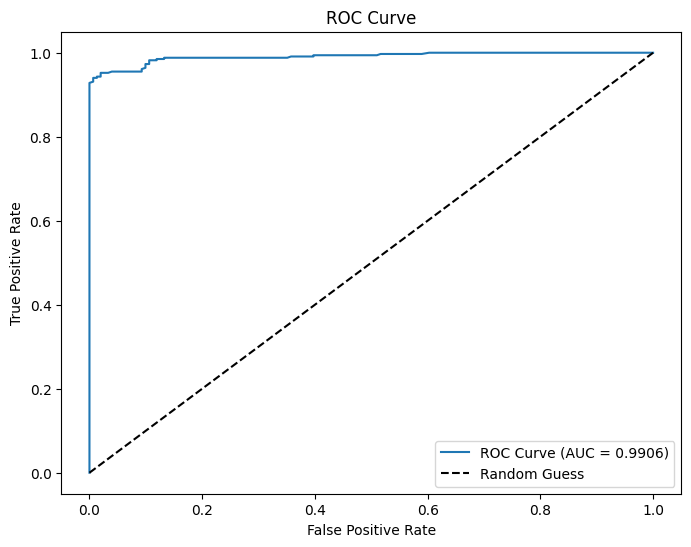

In [ ]:
# Use probability of the positive class (y=1)
evaluator = BinaryClassificationEvaluator(labelCol="fail", rawPredictionCol="prediction_lr", metricName="areaUnderROC")

# Evaluate AUC
auc = evaluator.evaluate(dtest_1)

print(f"AUC: {auc:.4f}")  # Higher is better (closer to 1)

# Convert to Pandas
pdf = dtest_1.select("prediction_lr", "fail").toPandas()

# Compute ROC curve
fpr, tpr, _ = roc_curve(pdf["fail"], pdf["prediction_lr"])

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Regularized Logistic Regression with Cross-Validation

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, roc_curve, roc_auc_score)

In [ ]:
cars = pd.read_csv('https://bcdanl.github.io/data/car-data.csv')
cars

,buying,maint,doors,persons,lug_boot,safety,rating,fail
0,vhigh,vhigh,2,2,small,low,unacc,1
1,vhigh,vhigh,2,2,small,med,unacc,1
2,vhigh,vhigh,2,2,small,high,unacc,1
3,vhigh,vhigh,2,2,med,low,unacc,1
4,vhigh,vhigh,2,2,med,med,unacc,1
...,...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good,0
1724,low,low,5more,more,med,high,vgood,0
1725,low,low,5more,more,big,low,unacc,1
1726,low,low,5more,more,big,med,good,0


In [ ]:
# Identify categorical columns (adjust the types if needed)
categorical_cols = (
    cars
    .select_dtypes(include=['object', 'category'])
    .columns
    .tolist()
)
categorical_cols.remove('rating')
categorical_cols

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']

In [ ]:
# Create dummy variables with a prefix for each categorical variable
dummies = pd.get_dummies(cars[categorical_cols], prefix=categorical_cols)

cars_with_dummies = pd.concat([cars.drop(categorical_cols, axis=1), dummies], axis=1)
cars_with_dummies = cars_with_dummies.drop('rating', axis=1)
cars_with_dummies

,fail,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,1,False,False,False,True,False,False,False,True,True,...,False,True,False,False,False,False,True,False,True,False
1,1,False,False,False,True,False,False,False,True,True,...,False,True,False,False,False,False,True,False,False,True
2,1,False,False,False,True,False,False,False,True,True,...,False,True,False,False,False,False,True,True,False,False
3,1,False,False,False,True,False,False,False,True,True,...,False,True,False,False,False,True,False,False,True,False
4,1,False,False,False,True,False,False,False,True,True,...,False,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,0,False,True,False,False,False,True,False,False,False,...,True,False,False,True,False,True,False,False,False,True
1724,0,False,True,False,False,False,True,False,False,False,...,True,False,False,True,False,True,False,True,False,False
1725,1,False,True,False,False,False,True,False,False,False,...,True,False,False,True,True,False,False,False,True,False
1726,0,False,True,False,False,False,True,False,False,False,...,True,False,False,True,True,False,False,False,False,True


In [ ]:
# Split into train and test (70% train, 30% test)

# Using a fixed random state for reproducibility (seed = 24351)
cars_train, cars_test = train_test_split(cars, test_size=0.3, random_state=24351)

# Define predictors: all columns except "rating" and "fail"
predictors = [col for col in cars.columns if col not in ['rating', 'fail']]

# One-hot encode categorical predictors.
X_train = pd.get_dummies(cars_train[predictors])
X_test = pd.get_dummies(cars_test[predictors])
# Ensure that the test set has the same dummy columns as the training set
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Outcome variable
y_train = cars_train['fail'].astype(int)
y_test = cars_test['fail'].astype(int)

## Ridge Regression (L2 Penalty)

Ridge Regression - Best C (inverse of regularization strength): 25.950242113997373
Ridge Regression Coefficients:
         predictor  coefficient
0      buying_high     2.088163
1       buying_low    -3.290036
2       buying_med    -1.826384
3     buying_vhigh     3.870633
4       maint_high     1.410526
5        maint_low    -2.232305
6        maint_med    -2.169268
7      maint_vhigh     3.833423
8          doors_2     1.572662
9          doors_3     0.197084
10         doors_4    -0.455927
11     doors_5more    -0.471443
12       persons_2     9.931083
13       persons_4    -4.765592
14    persons_more    -4.323115
15    lug_boot_big    -1.346707
16    lug_boot_med    -0.209493
17  lug_boot_small     2.398576
18     safety_high    -5.770078
19      safety_low     9.416235
20      safety_med    -2.803781


<ipython-input-9-af48f9467d2e>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercept = float(ridge_cv.intercept_)
<ipython-input-9-af48f9467d2e>:20: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(x="coefficient", y="predictor", data=coef_ridge, order=order, join=False)


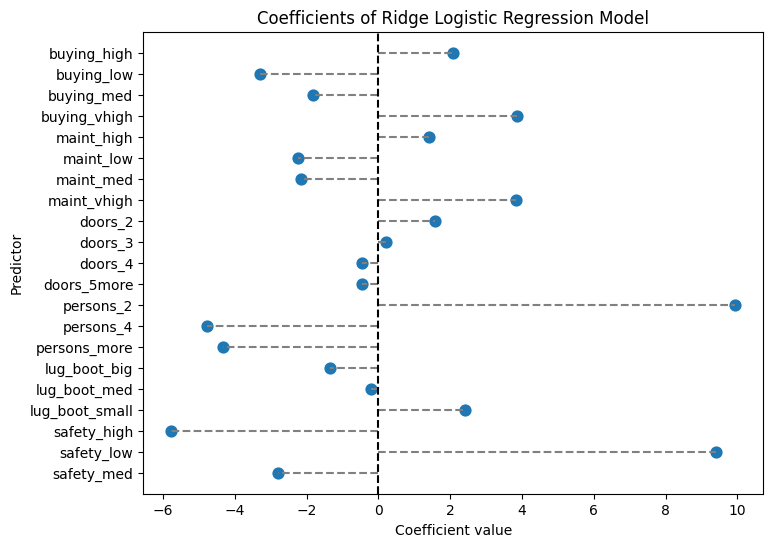

Confusion Matrix (Ridge):
 [[156  16]
 [  8 339]]
Ridge Accuracy: 0.953757225433526
Ridge Precision: 0.9549295774647887
Ridge Recall: 0.9769452449567724


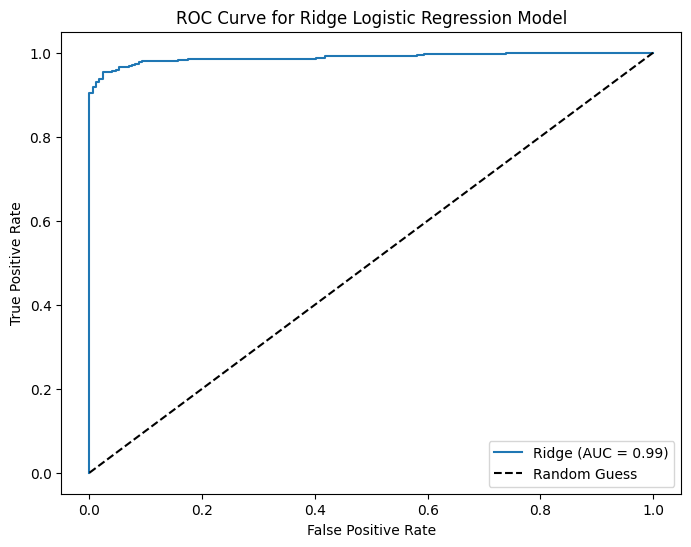

In [ ]:
# LogisticRegressionCV automatically selects the best regularization strength.
ridge_cv = LogisticRegressionCV(
    Cs=100, cv=5, penalty='l2', solver='lbfgs', max_iter=1000, scoring='neg_log_loss'
)
ridge_cv.fit(X_train, y_train)

print("Ridge Regression - Best C (inverse of regularization strength):", ridge_cv.C_[0])
intercept = float(ridge_cv.intercept_)
coef_ridge = pd.DataFrame({
    'predictor': list(X_train.columns),
    'coefficient': list(ridge_cv.coef_[0])
})
print("Ridge Regression Coefficients:")
print(coef_ridge)

# Force an order for the y-axis (using the feature names as they appear in coef_ridge)
order = coef_ridge['predictor'].tolist()

plt.figure(figsize=(8,6))
ax = sns.pointplot(x="coefficient", y="predictor", data=coef_ridge, order=order, join=False)
plt.title("Coefficients of Ridge Logistic Regression Model")
plt.xlabel("Coefficient value")
plt.ylabel("Predictor")

# Draw horizontal lines from 0 to each coefficient.
for _, row in coef_ridge.iterrows():
    # Get the y-axis position from the order list.
    y_pos = order.index(row['predictor'])
    plt.hlines(y=y_pos, xmin=0, xmax=row['coefficient'], color='gray', linestyle='--')

# Draw a vertical line at 0.
plt.axvline(0, color='black', linestyle='--')
plt.show()

# Prediction and evaluation for ridge model
y_pred_prob_ridge = ridge_cv.predict_proba(X_test)[:, 1]
y_pred_ridge = (y_pred_prob_ridge > 0.5).astype(int)
ctab_ridge = confusion_matrix(y_test, y_pred_ridge)
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
precision_ridge = precision_score(y_test, y_pred_ridge)
recall_ridge = recall_score(y_test, y_pred_ridge)
auc_ridge = roc_auc_score(y_test, y_pred_prob_ridge)

print("Confusion Matrix (Ridge):\n", ctab_ridge)
print("Ridge Accuracy:", accuracy_ridge)
print("Ridge Precision:", precision_ridge)
print("Ridge Recall:", recall_ridge)


# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_ridge)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Ridge (AUC = {auc_ridge:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ridge Logistic Regression Model')
plt.legend(loc='best')
plt.show()


## Lasso Regression (L1 Penalty)

<ipython-input-15-e49fc55eb761>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercept = float(lasso_cv.intercept_)
<ipython-input-15-e49fc55eb761>:20: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(x="coefficient", y="predictor", data=coef_lasso, order=order, join=False)


Lasso Regression Coefficients:
         predictor  coefficient
0      buying_high     1.787892
1       buying_low    -3.593632
2       buying_med    -2.081475
3     buying_vhigh     3.567813
4       maint_high     1.225046
5        maint_low    -2.391010
6        maint_med    -2.326250
7      maint_vhigh     3.654059
8          doors_2     1.515634
9          doors_3     0.133811
10         doors_4    -0.473203
11     doors_5more    -0.488640
12       persons_2    14.899017
13       persons_4    -0.422268
14    persons_more     0.000000
15    lug_boot_big    -1.138295
16    lug_boot_med     0.000000
17  lug_boot_small     2.590292
18     safety_high    -2.953921
19      safety_low    12.819173
20      safety_med     0.000000


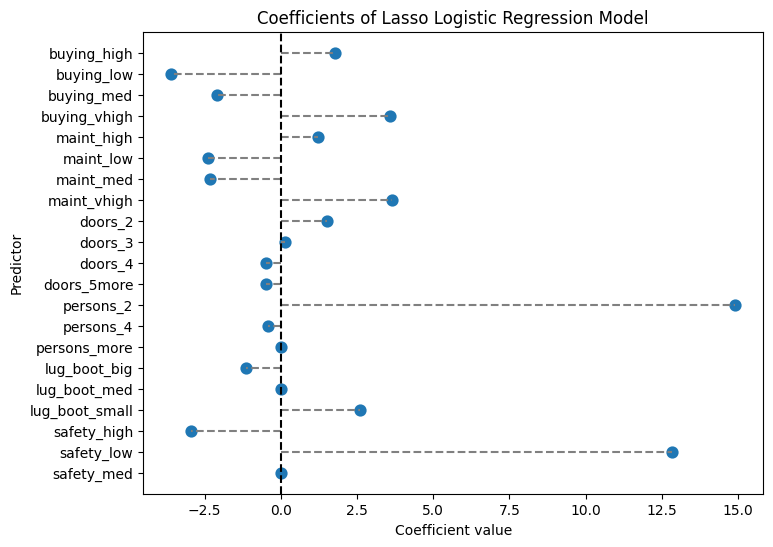

Confusion Matrix (Lasso):
 [[156  16]
 [  9 338]]
Lasso Accuracy: 0.9518304431599229
Lasso Precision: 0.9548022598870056
Lasso Recall: 0.9740634005763689


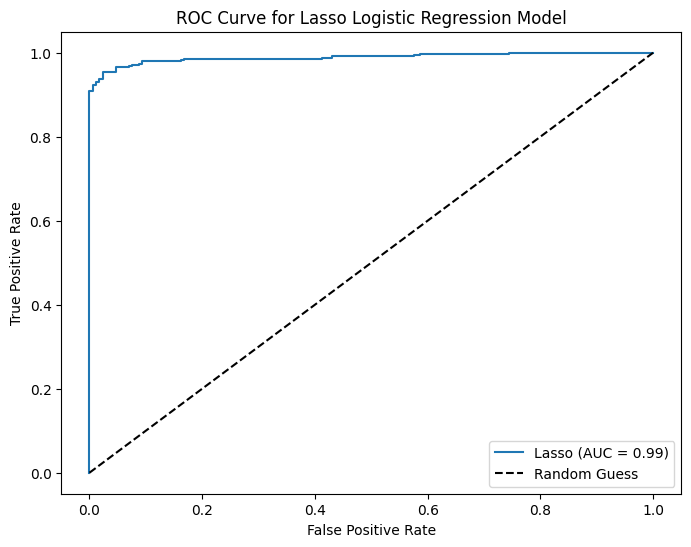

In [ ]:
# Note: solver='saga' supports L1 regularization.
lasso_cv = LogisticRegressionCV(
    Cs=100, cv=5, penalty='l1', solver='saga', max_iter=1000, scoring='neg_log_loss'
)
lasso_cv.fit(X_train, y_train)

intercept = float(lasso_cv.intercept_)
coef_lasso = pd.DataFrame({
    'predictor': list(X_train.columns),
    'coefficient': list(lasso_cv.coef_[0])
})

print("Lasso Regression Coefficients:")
print(coef_lasso)

# Force an order for the y-axis (using the feature names as they appear in coef_lasso)
order = coef_lasso['predictor'].tolist()

plt.figure(figsize=(8,6))
ax = sns.pointplot(x="coefficient", y="predictor", data=coef_lasso, order=order, join=False)
plt.title("Coefficients of Lasso Logistic Regression Model")
plt.xlabel("Coefficient value")
plt.ylabel("Predictor")

# Draw horizontal lines from 0 to each coefficient.
for _, row in coef_lasso.iterrows():
    # Get the y-axis position from the order list.
    y_pos = order.index(row['predictor'])
    plt.hlines(y=y_pos, xmin=0, xmax=row['coefficient'], color='gray', linestyle='--')

# Draw a vertical line at 0.
plt.axvline(0, color='black', linestyle='--')

plt.show()

# Prediction and evaluation for lasso model
y_pred_prob_lasso = lasso_cv.predict_proba(X_test)[:, 1]
y_pred_lasso = (y_pred_prob_lasso > 0.5).astype(int)
ctab_lasso = confusion_matrix(y_test, y_pred_lasso)
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
precision_lasso = precision_score(y_test, y_pred_lasso)
recall_lasso = recall_score(y_test, y_pred_lasso)
auc_lasso = roc_auc_score(y_test, y_pred_prob_lasso)

print("Confusion Matrix (Lasso):\n", ctab_lasso)
print("Lasso Accuracy:", accuracy_lasso)
print("Lasso Precision:", precision_lasso)
print("Lasso Recall:", recall_lasso)


# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lasso)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Lasso (AUC = {auc_ridge:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Lasso Logistic Regression Model')
plt.legend(loc='best')
plt.show()


## Elastic Net Regression

Elastic Net Regression - Best C: 21.54434690031882
Elastic Net Regression - Best l1 ratio: 0.5
Elastic Net Regression Coefficients:
         predictor  coefficient
0        Intercept     5.607714
1      buying_high     2.155057
2       buying_low    -3.449854
3       buying_med    -1.896770
4     buying_vhigh     4.001764
5       maint_high     1.448343
6        maint_low    -2.337030
7        maint_med    -2.269264
8      maint_vhigh     3.968147
9          doors_2     1.628000
10         doors_3     0.208917
11         doors_4    -0.471257
12     doors_5more    -0.490440
13       persons_2    10.914849
14       persons_4    -4.779511
15    persons_more    -4.325142
16    lug_boot_big    -1.210976
17    lug_boot_med    -0.008686
18  lug_boot_small     2.681634
19     safety_high    -5.815110
20      safety_low    10.355200
21      safety_med    -2.729894


<ipython-input-14-09a95d5a8840>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercept = float(enet_cv.intercept_)
<ipython-input-14-09a95d5a8840>:25: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(x="coefficient", y="predictor", data=coef_enet, order=order, join=False)


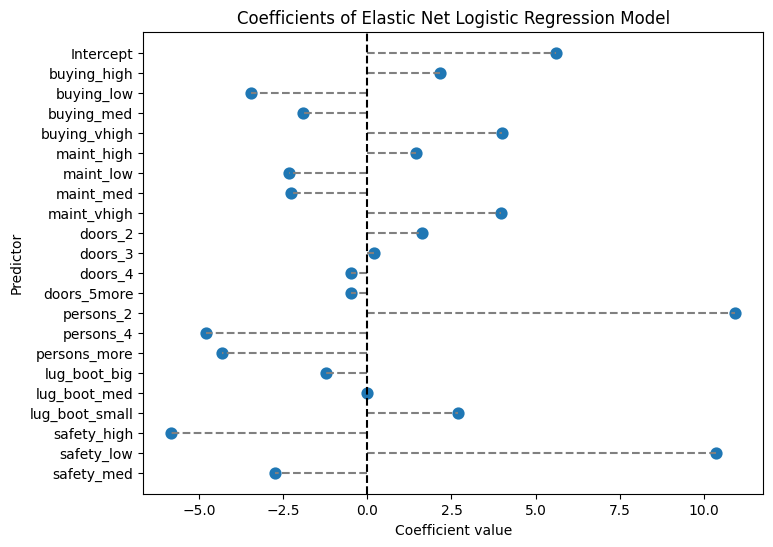

Confusion Matrix (Elastic Net):
 [[156  16]
 [  8 339]]
Elastic Net Accuracy: 0.953757225433526
Elastic Net Precision: 0.9549295774647887
Elastic Net Recall: 0.9769452449567724


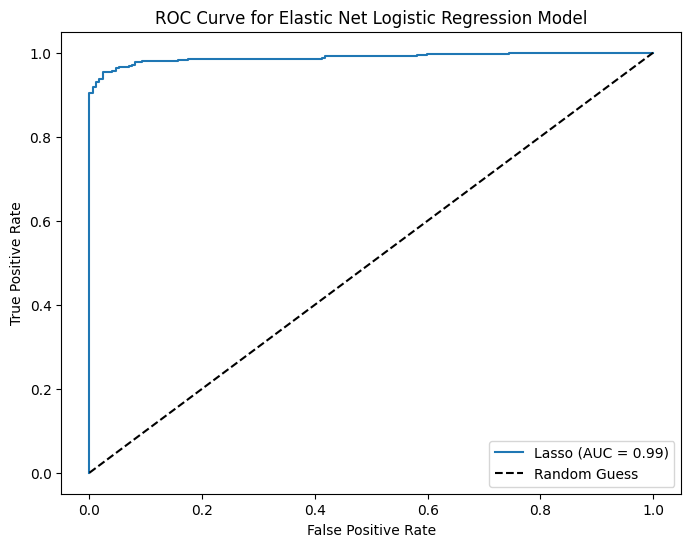

In [ ]:
# LogisticRegressionCV supports elastic net penalty with solver 'saga'.
# l1_ratio specifies the mix between L1 and L2 (0 = ridge, 1 = lasso).
enet_cv = LogisticRegressionCV(
    Cs=10, cv=5, penalty='elasticnet', solver='saga',
    l1_ratios=[0.5, 0.7, 0.9], max_iter=1000, scoring='neg_log_loss'
)
enet_cv.fit(X_train, y_train)

print("Elastic Net Regression - Best C:", enet_cv.C_[0])
print("Elastic Net Regression - Best l1 ratio:", enet_cv.l1_ratio_[0])

intercept = float(enet_cv.intercept_)
coef_enet = pd.DataFrame({
    'predictor': list(X_train.columns),
    'coefficient': list(enet_cv.coef_[0])
})
print("Elastic Net Regression Coefficients:")
print(coef_enet)


# Force an order for the y-axis (using the feature names as they appear in coef_lasso)
order = coef_enet['predictor'].tolist()

plt.figure(figsize=(8,6))
ax = sns.pointplot(x="coefficient", y="predictor", data=coef_enet, order=order, join=False)
plt.title("Coefficients of Elastic Net Logistic Regression Model")
plt.xlabel("Coefficient value")
plt.ylabel("Predictor")

# Draw horizontal lines from 0 to each coefficient.
for _, row in coef_enet.iterrows():
    # Get the y-axis position from the order list.
    y_pos = order.index(row['predictor'])
    plt.hlines(y=y_pos, xmin=0, xmax=row['coefficient'], color='gray', linestyle='--')

# Draw a vertical line at 0.
plt.axvline(0, color='black', linestyle='--')

plt.show()

# Prediction and evaluation for elastic net model
y_pred_prob_enet = enet_cv.predict_proba(X_test)[:, 1]
y_pred_enet = (y_pred_prob_enet > 0.5).astype(int)
ctab_enet = confusion_matrix(y_test, y_pred_enet)
accuracy_enet = accuracy_score(y_test, y_pred_enet)
precision_enet = precision_score(y_test, y_pred_enet)
recall_enet = recall_score(y_test, y_pred_enet)

print("Confusion Matrix (Elastic Net):\n", ctab_enet)
print("Elastic Net Accuracy:", accuracy_enet)
print("Elastic Net Precision:", precision_enet)
print("Elastic Net Recall:", recall_enet)


# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_enet)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Lasso (AUC = {auc_ridge:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Elastic Net Logistic Regression Model')
plt.legend(loc='best')
plt.show()


# With DataFrame.values

- We can save code running time by using `DataFrame.values`

In [ ]:
# Note: solver='saga' supports L1 regularization.
lasso_cv = LogisticRegressionCV(
    Cs=100, cv=5, penalty='l1', solver='saga', max_iter=1000, scoring='neg_log_loss'
)
lasso_cv.fit(X_train.values, y_train.values)

intercept = float(lasso_cv.intercept_)
coef_lasso = pd.DataFrame({
    'predictor': ['Intercept'] + list(X_train.columns),
    'coefficient': [intercept] + list(lasso_cv.coef_[0])
})

print("Lasso Regression Coefficients:")
print(coef_lasso)

# Force an order for the y-axis (using the feature names as they appear in coef_lasso)
order = coef_lasso['predictor'].tolist()

plt.figure(figsize=(8,6))
ax = sns.pointplot(x="coefficient", y="predictor", data=coef_lasso, order=order, join=False)
plt.title("Coefficients of Lasso Logistic Regression Model")
plt.xlabel("Coefficient value")
plt.ylabel("Predictor")

# Draw horizontal lines from 0 to each coefficient.
for _, row in coef_lasso.iterrows():
    # Get the y-axis position from the order list.
    y_pos = order.index(row['predictor'])
    plt.hlines(y=y_pos, xmin=0, xmax=row['coefficient'], color='gray', linestyle='--')

# Draw a vertical line at 0.
plt.axvline(0, color='black', linestyle='--')

plt.show()

# Prediction and evaluation for lasso model
y_pred_prob_lasso = lasso_cv.predict_proba(X_test)[:, 1]
y_pred_lasso = (y_pred_prob_lasso > 0.5).astype(int)
ctab_lasso = confusion_matrix(y_test, y_pred_lasso)
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
precision_lasso = precision_score(y_test, y_pred_lasso)
recall_lasso = recall_score(y_test, y_pred_lasso)
auc_lasso = roc_auc_score(y_test, y_pred_prob_lasso)

print("Confusion Matrix (Lasso):\n", ctab_lasso)
print("Lasso Accuracy:", accuracy_lasso)
print("Lasso Precision:", precision_lasso)
print("Lasso Recall:", recall_lasso)


# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lasso)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Lasso (AUC = {auc_ridge:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Lasso Logistic Regression Model')
plt.legend(loc='best')
plt.show()
